<a href="https://colab.research.google.com/github/dyaccu/Hackathon2025_Proyecto3_FlightOnTime/blob/main/Validaci%C3%B3n_cruzada_estratificada_del_modelo_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**📌 Celda — Validación Cruzada Estratificada**

> Nota: En este notebook se mantiene la misma definición de features (X) y target (y) utilizada en el modelo base.  
> No se modifican las variables originales ni el split conceptual del problema; únicamente se cambia el esquema de evaluación, usando validación cruzada estratificada.


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.metrics import classification_report

# ----------------------------------------------
# 1) Cargar el dataset
# ----------------------------------------------
URL_DATASET = "https://raw.githubusercontent.com/NoCountry-vuelos-Team/nocountry-data-science/refs/heads/demo/docs/data/archivo_limpio.csv"
df = pd.read_csv(URL_DATASET)

X = df.drop("retraso", axis=1)
y = df["retraso"]

cat_features = X.select_dtypes(include="object").columns.tolist()
num_features = X.select_dtypes(exclude="object").columns.tolist()

# ----------------------------------------------
# 2) Preprocesamiento
# ----------------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

# ----------------------------------------------
# 3) Modelo seleccionado
# ----------------------------------------------
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

pipeline = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", model)
])

# ----------------------------------------------
# 4) Validación cruzada estratificada
# ----------------------------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

roc_auc_scores = []
recall_delay_scores = []

fold = 1
for train_idx, val_idx in skf.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Entrenar
    pipeline.fit(X_train, y_train)

    # Predecir probas para ROC-AUC
    probas = pipeline.predict_proba(X_val)[:, 1]

    # Predecir etiquetas para Recall
    preds = pipeline.predict(X_val)

    # Calcular métricas
    roc_auc = roc_auc_score(y_val, probas)
    recall_delay = recall_score(y_val, preds, pos_label=1)

    roc_auc_scores.append(roc_auc)
    recall_delay_scores.append(recall_delay)

    print(f"Fold {fold}: ROC AUC = {roc_auc:.4f} - Recall Delay = {recall_delay:.4f}")
    fold += 1

# ----------------------------------------------
# 5) Reporte final
# ----------------------------------------------

print("\n=== RESULTADOS FINALES ===")
print(f"ROC AUC - Mean: {np.mean(roc_auc_scores):.4f} | Std: {np.std(roc_auc_scores):.4f}")
print(f"Recall (delay=1) - Mean: {np.mean(recall_delay_scores):.4f} | Std: {np.std(recall_delay_scores):.4f}")


Fold 1: ROC AUC = 0.8599 - Recall Delay = 0.7404
Fold 2: ROC AUC = 0.8648 - Recall Delay = 0.7457
Fold 3: ROC AUC = 0.8616 - Recall Delay = 0.7437
Fold 4: ROC AUC = 0.8633 - Recall Delay = 0.7482
Fold 5: ROC AUC = 0.8666 - Recall Delay = 0.7524

=== RESULTADOS FINALES ===
ROC AUC - Mean: 0.8632 | Std: 0.0024
Recall (delay=1) - Mean: 0.7461 | Std: 0.0041


In [2]:
import pandas as pd

df_cv = pd.DataFrame({
    "Fold": range(1, 6),
    "ROC_AUC": roc_auc_scores,
    "Recall_delay": recall_delay_scores
})
df_cv


,Fold,ROC_AUC,Recall_delay
0,1,0.859857,0.740367
1,2,0.864753,0.745694
2,3,0.861650,0.743654
3,4,0.863296,0.748187
4,5,0.866639,0.752408


📊 Boxplot de ROC AUC

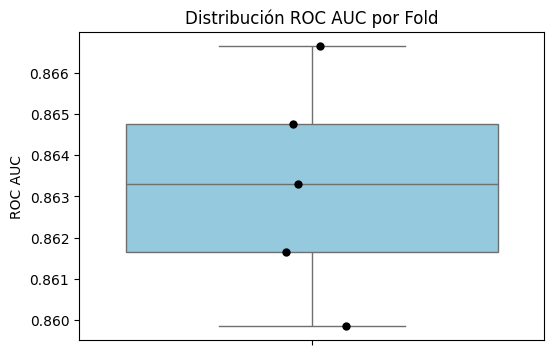

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.boxplot(y=df_cv["ROC_AUC"], color="skyblue")
sns.stripplot(y=df_cv["ROC_AUC"], color="black", size=6)
plt.title("Distribución ROC AUC por Fold")
plt.ylabel("ROC AUC")
plt.show()


📊 Boxplot de Recall (clase delay)

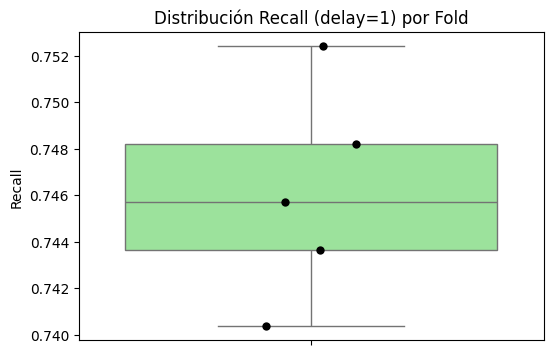

In [4]:
plt.figure(figsize=(6,4))
sns.boxplot(y=df_cv["Recall_delay"], color="lightgreen")
sns.stripplot(y=df_cv["Recall_delay"], color="black", size=6)
plt.title("Distribución Recall (delay=1) por Fold")
plt.ylabel("Recall")
plt.show()


📈 Gráfico de líneas por fold (ROC AUC y Recall)

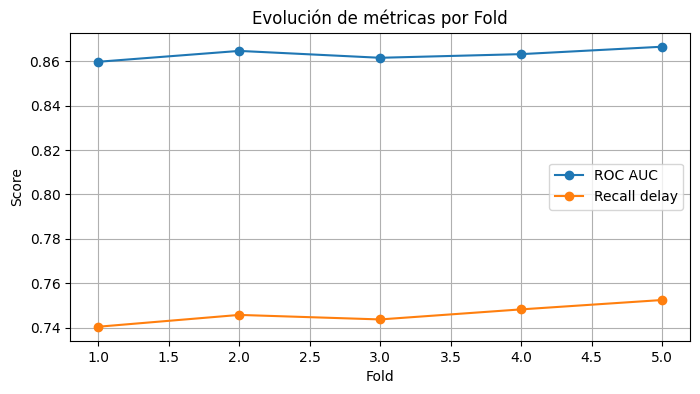

In [5]:
plt.figure(figsize=(8,4))
plt.plot(df_cv["Fold"], df_cv["ROC_AUC"], marker="o", label="ROC AUC")
plt.plot(df_cv["Fold"], df_cv["Recall_delay"], marker="o", label="Recall delay")
plt.xlabel("Fold")
plt.ylabel("Score")
plt.title("Evolución de métricas por Fold")
plt.legend()
plt.grid(True)
plt.show()


## 🧠 Insights Finales de la Validación Cruzada

Para evaluar la robustez del modelo se aplicó una validación cruzada estratificada con 5 folds, manteniendo la proporción original de clases. A continuación se integran los resultados numéricos y gráficos obtenidos:

### ✔️ Estabilidad del modelo
Las métricas ROC AUC y Recall (clase delay=1) mostraron una variación mínima entre folds:

- **ROC AUC:** entre 0.8598 y 0.8666  
- **Recall delay:** entre 0.7403 y 0.7524  

Esta estabilidad indica que el modelo no depende de una partición específica del dataset y generaliza correctamente.

### ✔️ Interpretación de los boxplots
Los boxplots de ROC AUC y Recall presentan cajas muy compactas, lo que evidencia baja dispersión y ausencia de valores atípicos.  
Esto confirma que el desempeño del modelo es uniforme a través de las diferentes particiones.

### ✔️ Interpretación del gráfico de líneas
Las curvas de ambos métricas evolucionan de manera suave sin saltos pronunciados, reforzando la idea de consistencia.  
ROC AUC se mantiene alrededor de 0.86 en todos los folds, y Recall alrededor de 0.74–0.75.

### ✔️ Conclusión general
El modelo Random Forest final es **robusto, estable y confiable**. Las métricas muestran:
- buena capacidad de discriminación (ROC AUC alto),
- buena detección de vuelos retrasados (Recall estable),
- y poca sensibilidad a la partición del dataset (std muy baja).

Esto valida que el modelo está listo para avanzar hacia la integración con backend, manteniendo un comportamiento consistente en ambientes reales.
